In [2]:
import os
import pandas as pd
import string
from datetime import datetime
from os import path
import json
import numpy as np
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import seaborn as sns
from plotting import compare_histograms

In [3]:
with open(path.expanduser("~") + "/sys_specific.json") as file: 
    params = json.load(file)
_HOME_ = params["home"] + "/PHD"

In [4]:
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params

In [88]:
df_chem_phys = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data.csv")

In [89]:
df_chem_phys["id"] = pd.Categorical(df_chem_phys["id"], categories=ordered_id, ordered=True)
df_chem_phys["Region"] = pd.Categorical(df_chem_phys["Region"], categories=ordered_regions, ordered=True)
df_chem_phys["Date"] = pd.to_datetime(df_chem_phys["Date"])
df_chem_phys["SampleDepth"] = df_chem_phys["SampleDepth"].astype("float")

In [90]:
depth_threshold = 2

In [91]:
simplified_chem_phys = df_chem_phys.query("SampleDepth <= @depth_threshold")

In [92]:
simplified_chem_phys = simplified_chem_phys.loc[~simplified_chem_phys["QF"].isin(["3", "4"]), :]

In [93]:
simplified_chem_phys.loc[:, "SampleDepth"] = simplified_chem_phys.loc[:, "SampleDepth"].apply(lambda x: round(x * 2) / 2)

In [94]:
nutrients = df_chem_phys["Nutrient"].unique()

In [95]:
simplified_chem_phys = dict([(nut, simplified_chem_phys.query("Nutrient == @nut")) for nut in nutrients])

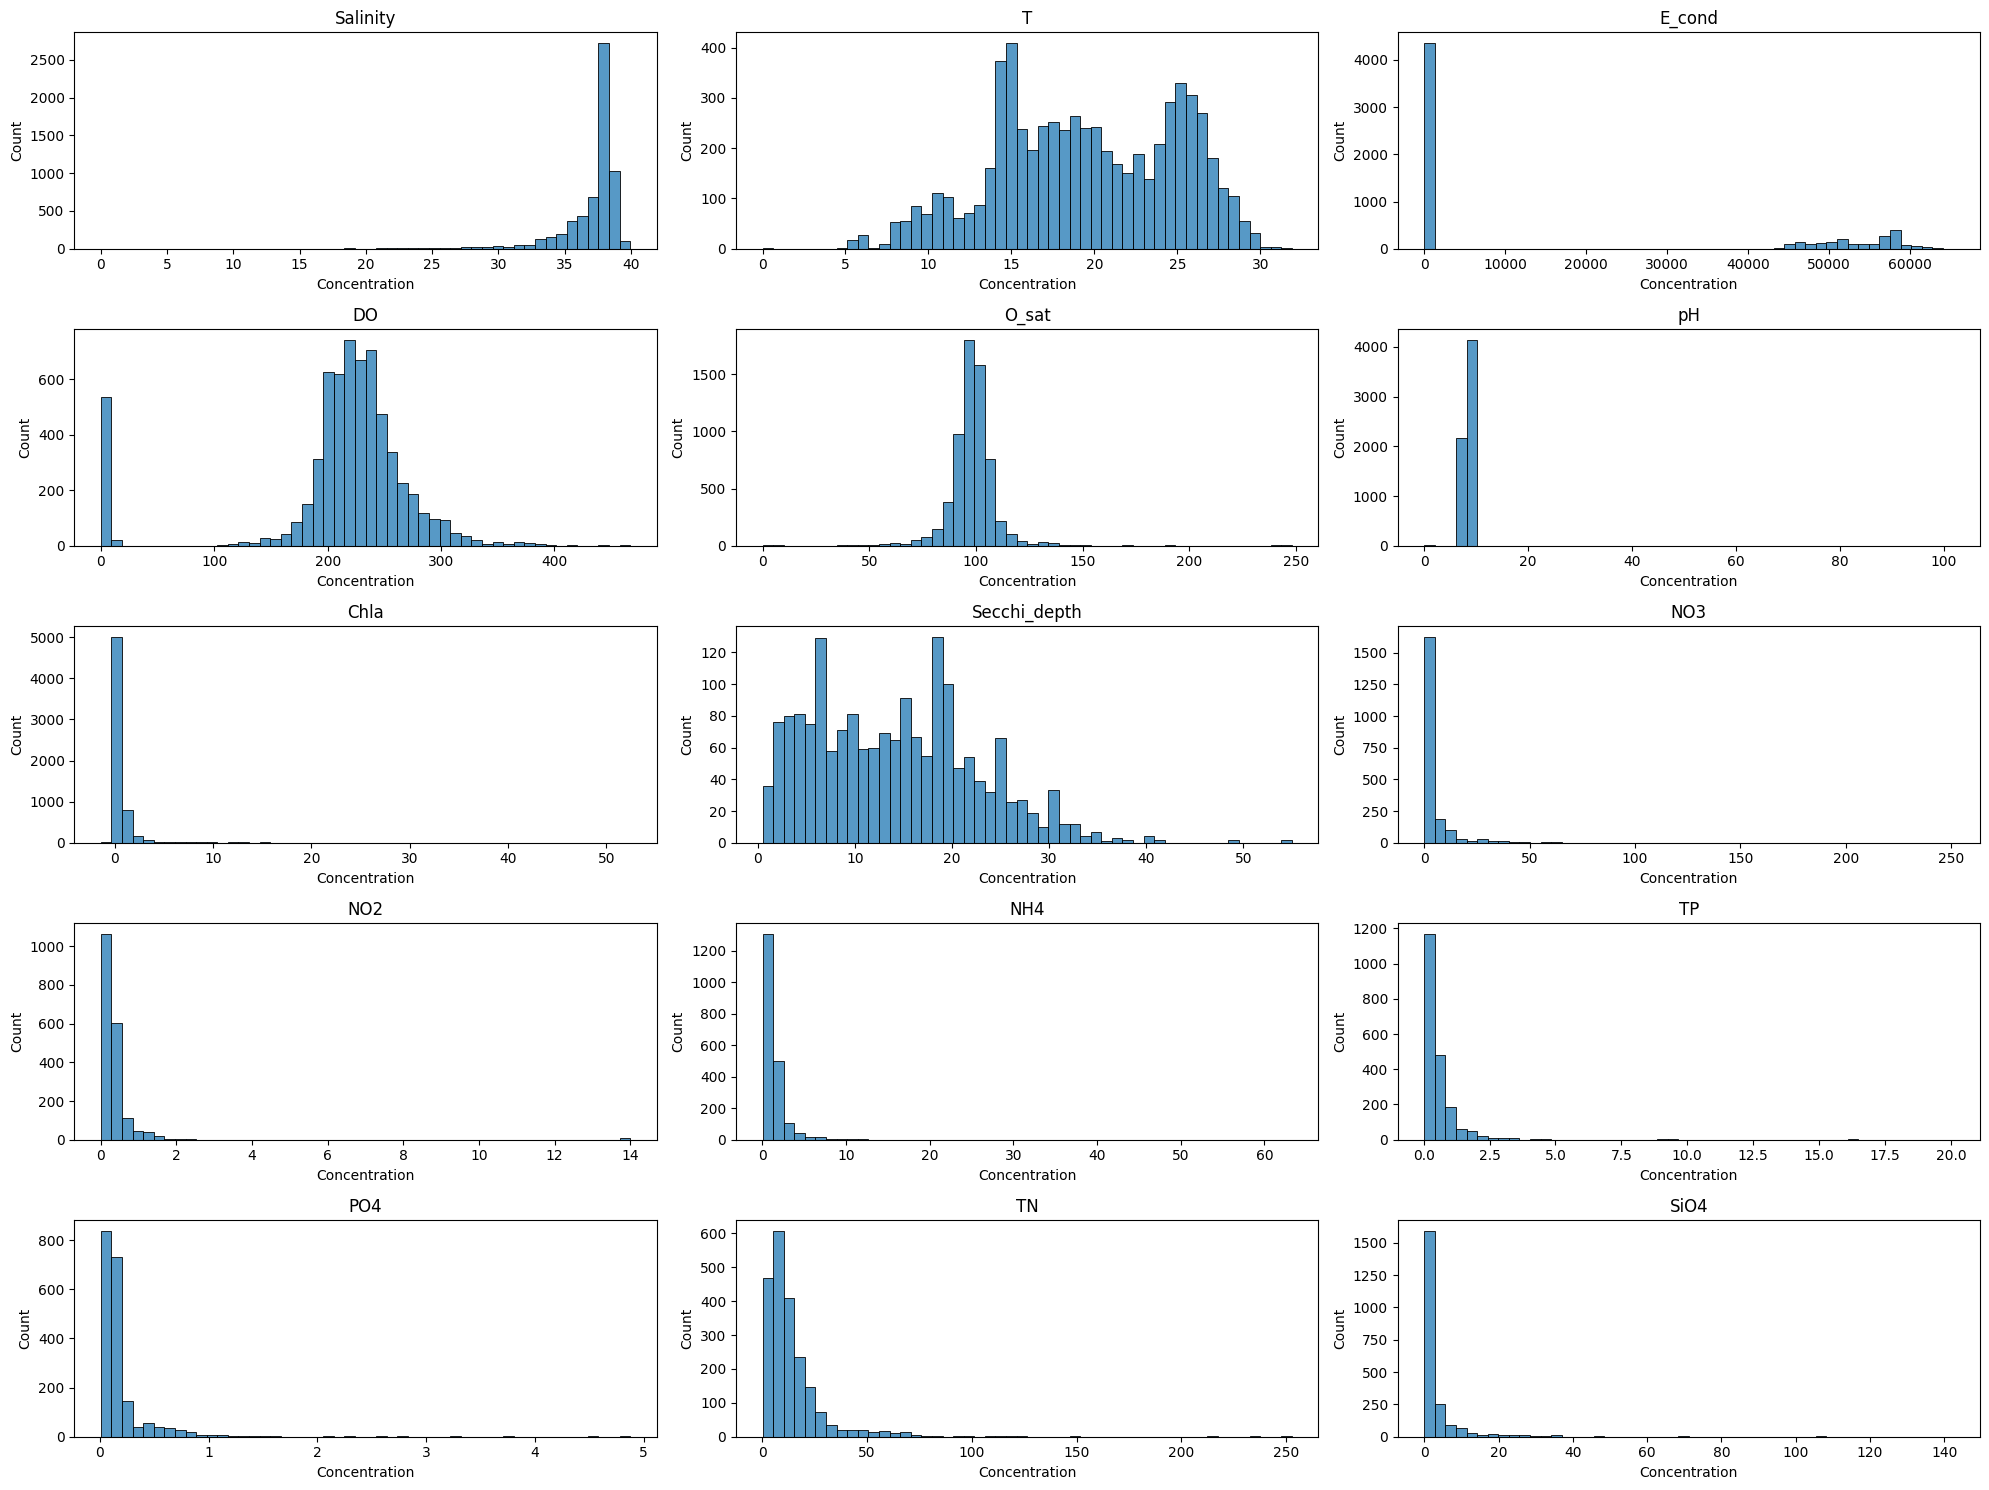

In [96]:
fig, axs = plt.subplots(5, 3, figsize=(20, 15))
axs = axs.ravel()
for (nut, ax) in zip(nutrients, axs):
    df_nut = simplified_chem_phys[nut]
    sns.histplot(data=df_nut, x="Concentration", ax=ax, bins=50)
    ax.set_title(nut)
plt.tight_layout()

In [97]:
expression = "Concentration > 2.5"
nut = "T"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [98]:
expression = "Concentration > 25 and Concentration < 200"
nut = "O_sat"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [104]:
expression = "Concentration <= 10 and Concentration >= 4"
nut = "pH"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)
simplified_chem_phys[nut] = simplified_chem_phys[nut].query("Region == 'Basilicata' or Concentration > 7")

In [105]:
expression = "Concentration <= 20 and Concentration >0"
nut = "Chla"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [106]:
expression = "Concentration <= 100"
nut = "NO3"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [107]:
expression = "Concentration <= 3"
nut = "PO4"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [108]:
expression = "Concentration <= 20"
nut = "NH4"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [109]:
expression = "Concentration <= 5"
nut = "TP"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [110]:
expression = "Concentration <= 150"
nut = "TN"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [111]:
expression = "Concentration <= 60"
nut = "SiO4"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [112]:
expression = "Concentration <= 6"
nut = "NO2"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [113]:
expression = "Concentration >= 100"
nut = "DO"
simplified_chem_phys[nut].loc[:, "Concentration"] = simplified_chem_phys[nut].loc[:, "Concentration"].apply(lambda x: x * 0.0821 * 298.15 if x < 100 else x)
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

In [114]:
expression = "Concentration >= 15"
nut = "Salinity"
simplified_chem_phys[nut] = simplified_chem_phys[nut].query(expression)

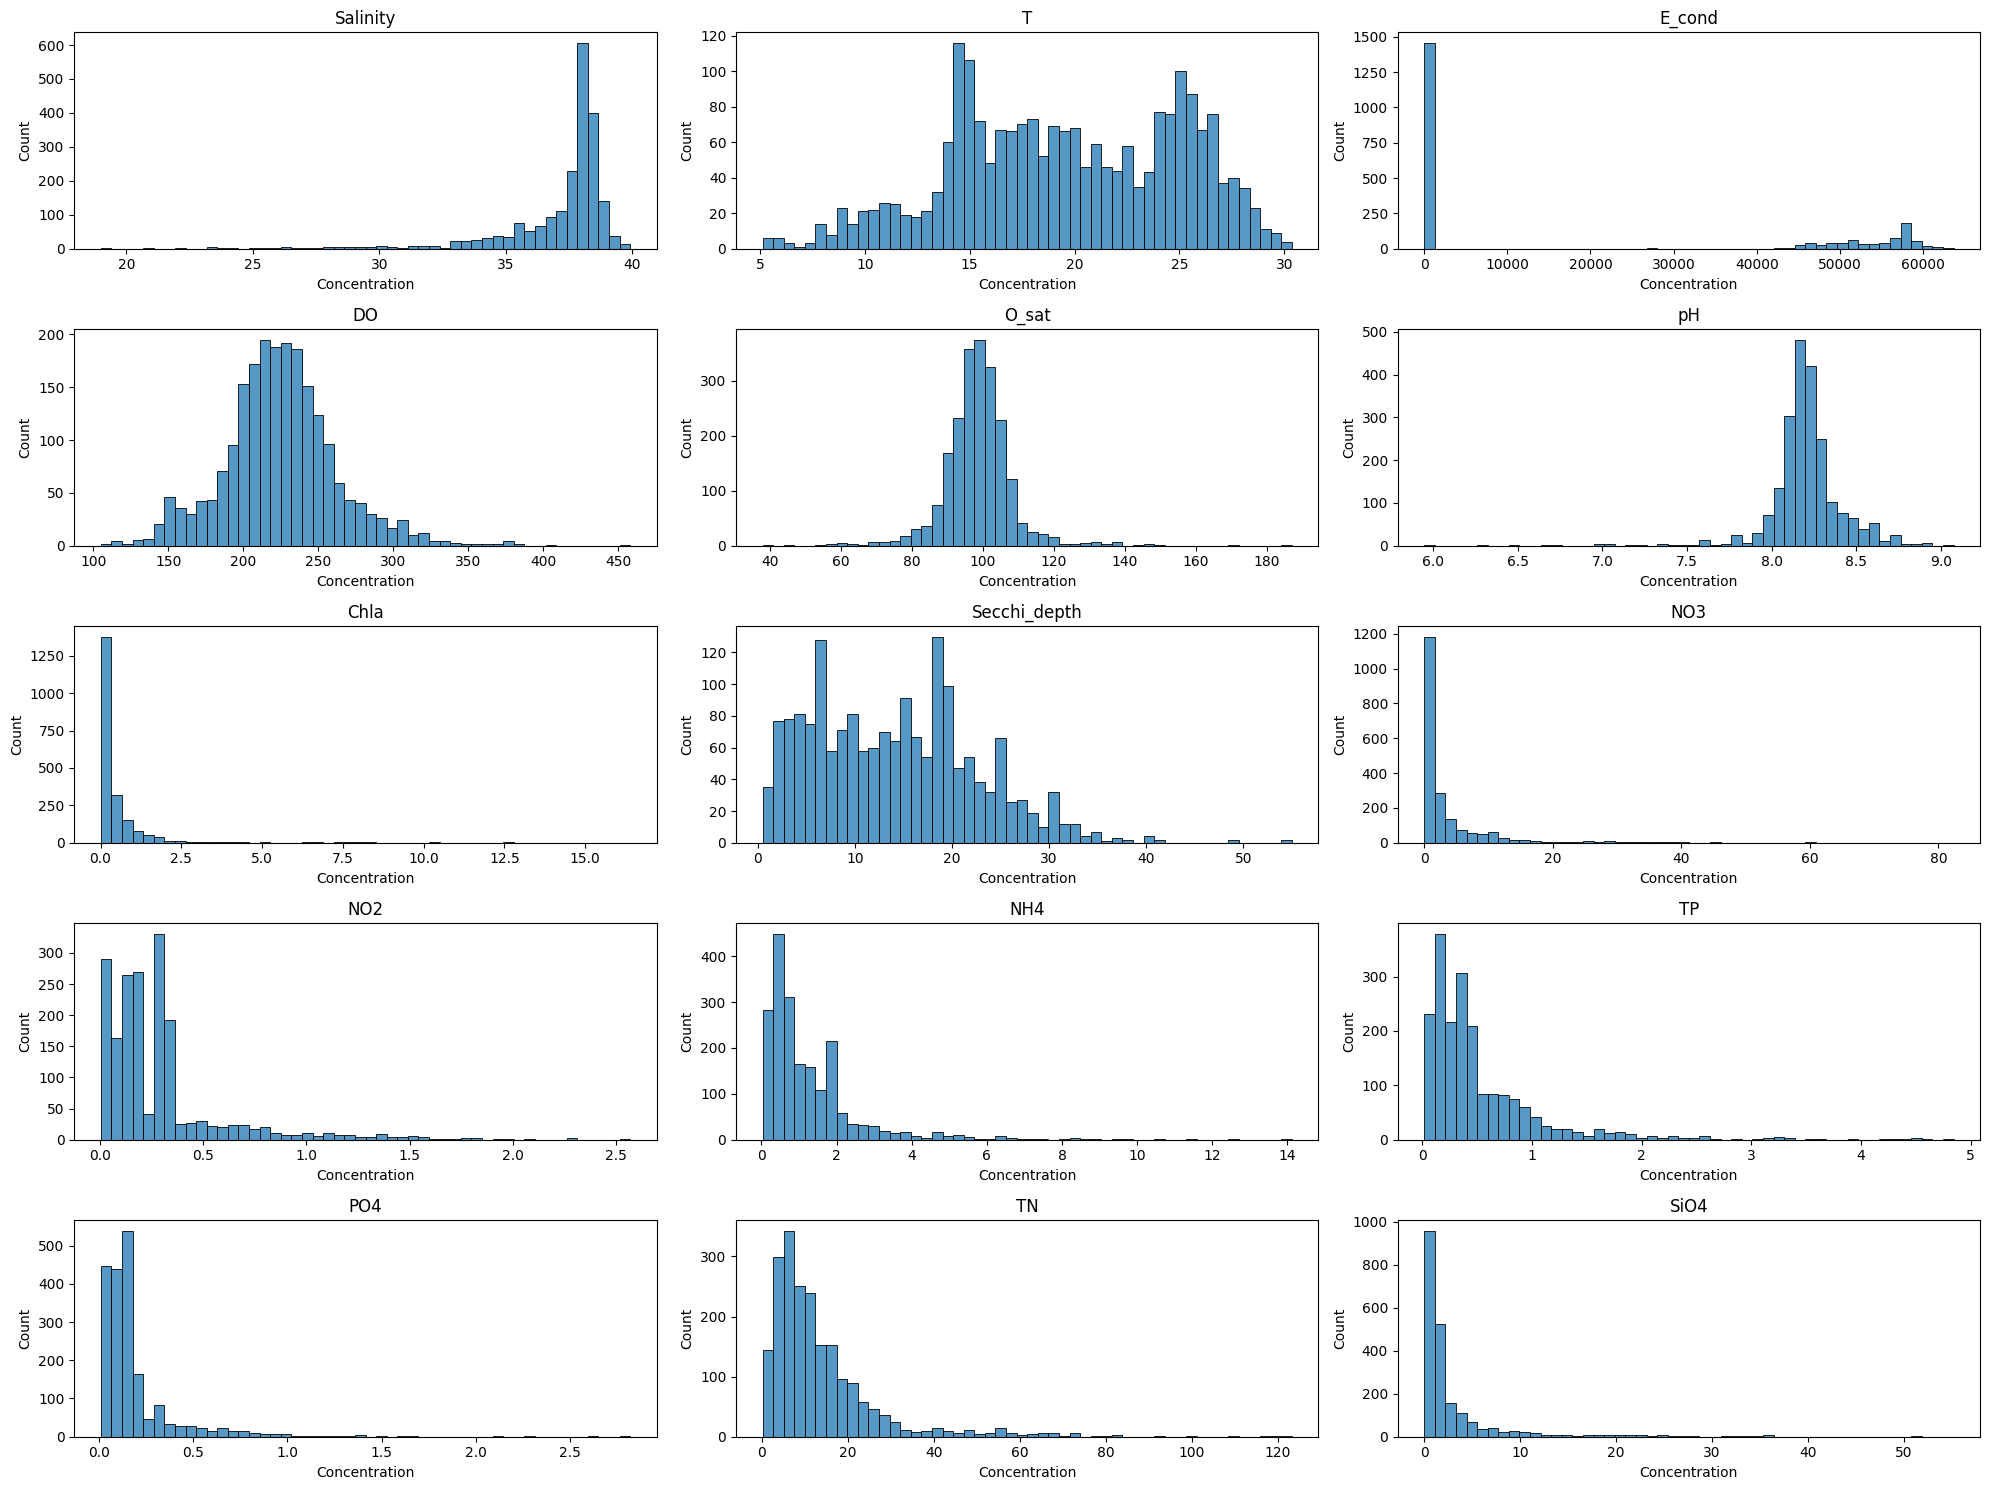

In [115]:
fig, axs = plt.subplots(5, 3, figsize=(20, 15))
axs = axs.ravel()
for ((nut, df_nut), ax) in zip(simplified_chem_phys.items(), axs):
    sns.histplot(data=df_nut.groupby(["id", "Date"], observed = True).mean(numeric_only = True), x="Concentration", ax=ax, bins=50)
    ax.set_title(nut)
plt.tight_layout()

In [203]:
N = len(simplified_chem_phys.keys())
min = np.zeros(N)
max = np.zeros(N)
nut_index = np.empty(N, dtype = "<U10")
for k, (nut, df_nut) in enumerate(simplified_chem_phys.items()):
    nut_index[k] = nut
    Q1 = df_nut["Concentration"].quantile(0.25)
    Q3 = df_nut["Concentration"].quantile(0.75)
    IQR = Q3 - Q1
    min[k] = Q1 - 1.5 * IQR
    max[k] = Q3 + 1.5 * IQR
outliers_df = pd.DataFrame(
    data = {
        "min" : min, 
        "max" : max
    }, 
    index = nut_index
)
outliers_df[outliers_df <= 0] = 0
outliers_df

,min,max
Salinity,34.377700,40.570500
T,1.108250,38.456650
E_cond,0.000000,122355.192525
DO,139.519775,308.300375
O_sat,80.150000,116.550000
pH,7.871000,8.535000
Chla,0.000000,1.175000
Secchi_dep,0.000000,39.500000
NO3,0.000000,8.920000
NO2,0.000000,0.727500


"<" quantiticabilità
"]" rilevabilità

In [204]:
for nut in nutrients: 
    print(nut, simplified_chem_phys[nut]["QF"].unique())

Salinity [nan '1']
T [nan '1']
E_cond [nan]
DO [nan '1']
O_sat [nan '<']
pH [nan]
Chla [nan '1' '<' 'Q']
Secchi_depth [nan '1']
NO3 [nan '1' 'Q' '<' '[' '6' '< ']
NO2 [nan '1' 'Q' '[' '<' '6' '< ']
NH4 [nan '1' 'Q' '<' '[' '6' '< ']
TP [nan '1' 'Q' '[' '6' '<' '< ']
PO4 [nan '1' 'Q' '[' '<' '6' '< ']
TN [nan '1' '[' 'Q' '<' '6']
SiO4 [nan '1' 'Q' '<' '[' '6']


In [116]:
for nut in nutrients: 
    good = ((simplified_chem_phys[nut]["QF"] == "1")| (simplified_chem_phys[nut]["QF"].isna()))
    simplified_chem_phys[nut].loc[good, "QF"] = 1
    simplified_chem_phys[nut].loc[~good, "QF"] = 0

In [117]:
#write data to excel file 
with pd.ExcelWriter(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data_cleaned.xlsx") as writer: 
    for nut in simplified_chem_phys.keys(): 
        simplified_chem_phys[nut].to_excel(writer, sheet_name=nut, index=False)

In [118]:
env_data = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data_cleaned.xlsx", sheet_name=None, dtype = {"QF" : str})
nutrients = list(env_data.keys())

In [156]:
modified_dfs = []
# Iterate through the dictionary
for key, df in env_data.items():
    # Rename the 'nutrient' column to the key name
    # Append the modified DataFrame to the list
    modified_dfs.append(df.groupby(["Region", "id", "Date"], observed = True).agg({"Concentration" : "mean", "Nutrient" : "first"}))
env_long_all = pd.concat(modified_dfs, axis=0)
env_long_all = env_long_all.pivot_table(index=["Region", "id", "Date"], columns="Nutrient", values="Concentration")

In [119]:
for nut in ["Chla", "NO3", "NO2", "NH4", "TP", "PO4", "TN", "SiO4"]: 
    # set to zero concentrations below level of detectability    # set to randon number values below level of quantification
    selection = simplified_chem_phys[nut]["QF"].isin(["<", "Q", "6", "["])
    simplified_chem_phys[nut].loc[selection, "Concentration"] = simplified_chem_phys[nut].loc[selection, "Concentration"].apply(lambda x: np.random.uniform(0, x))

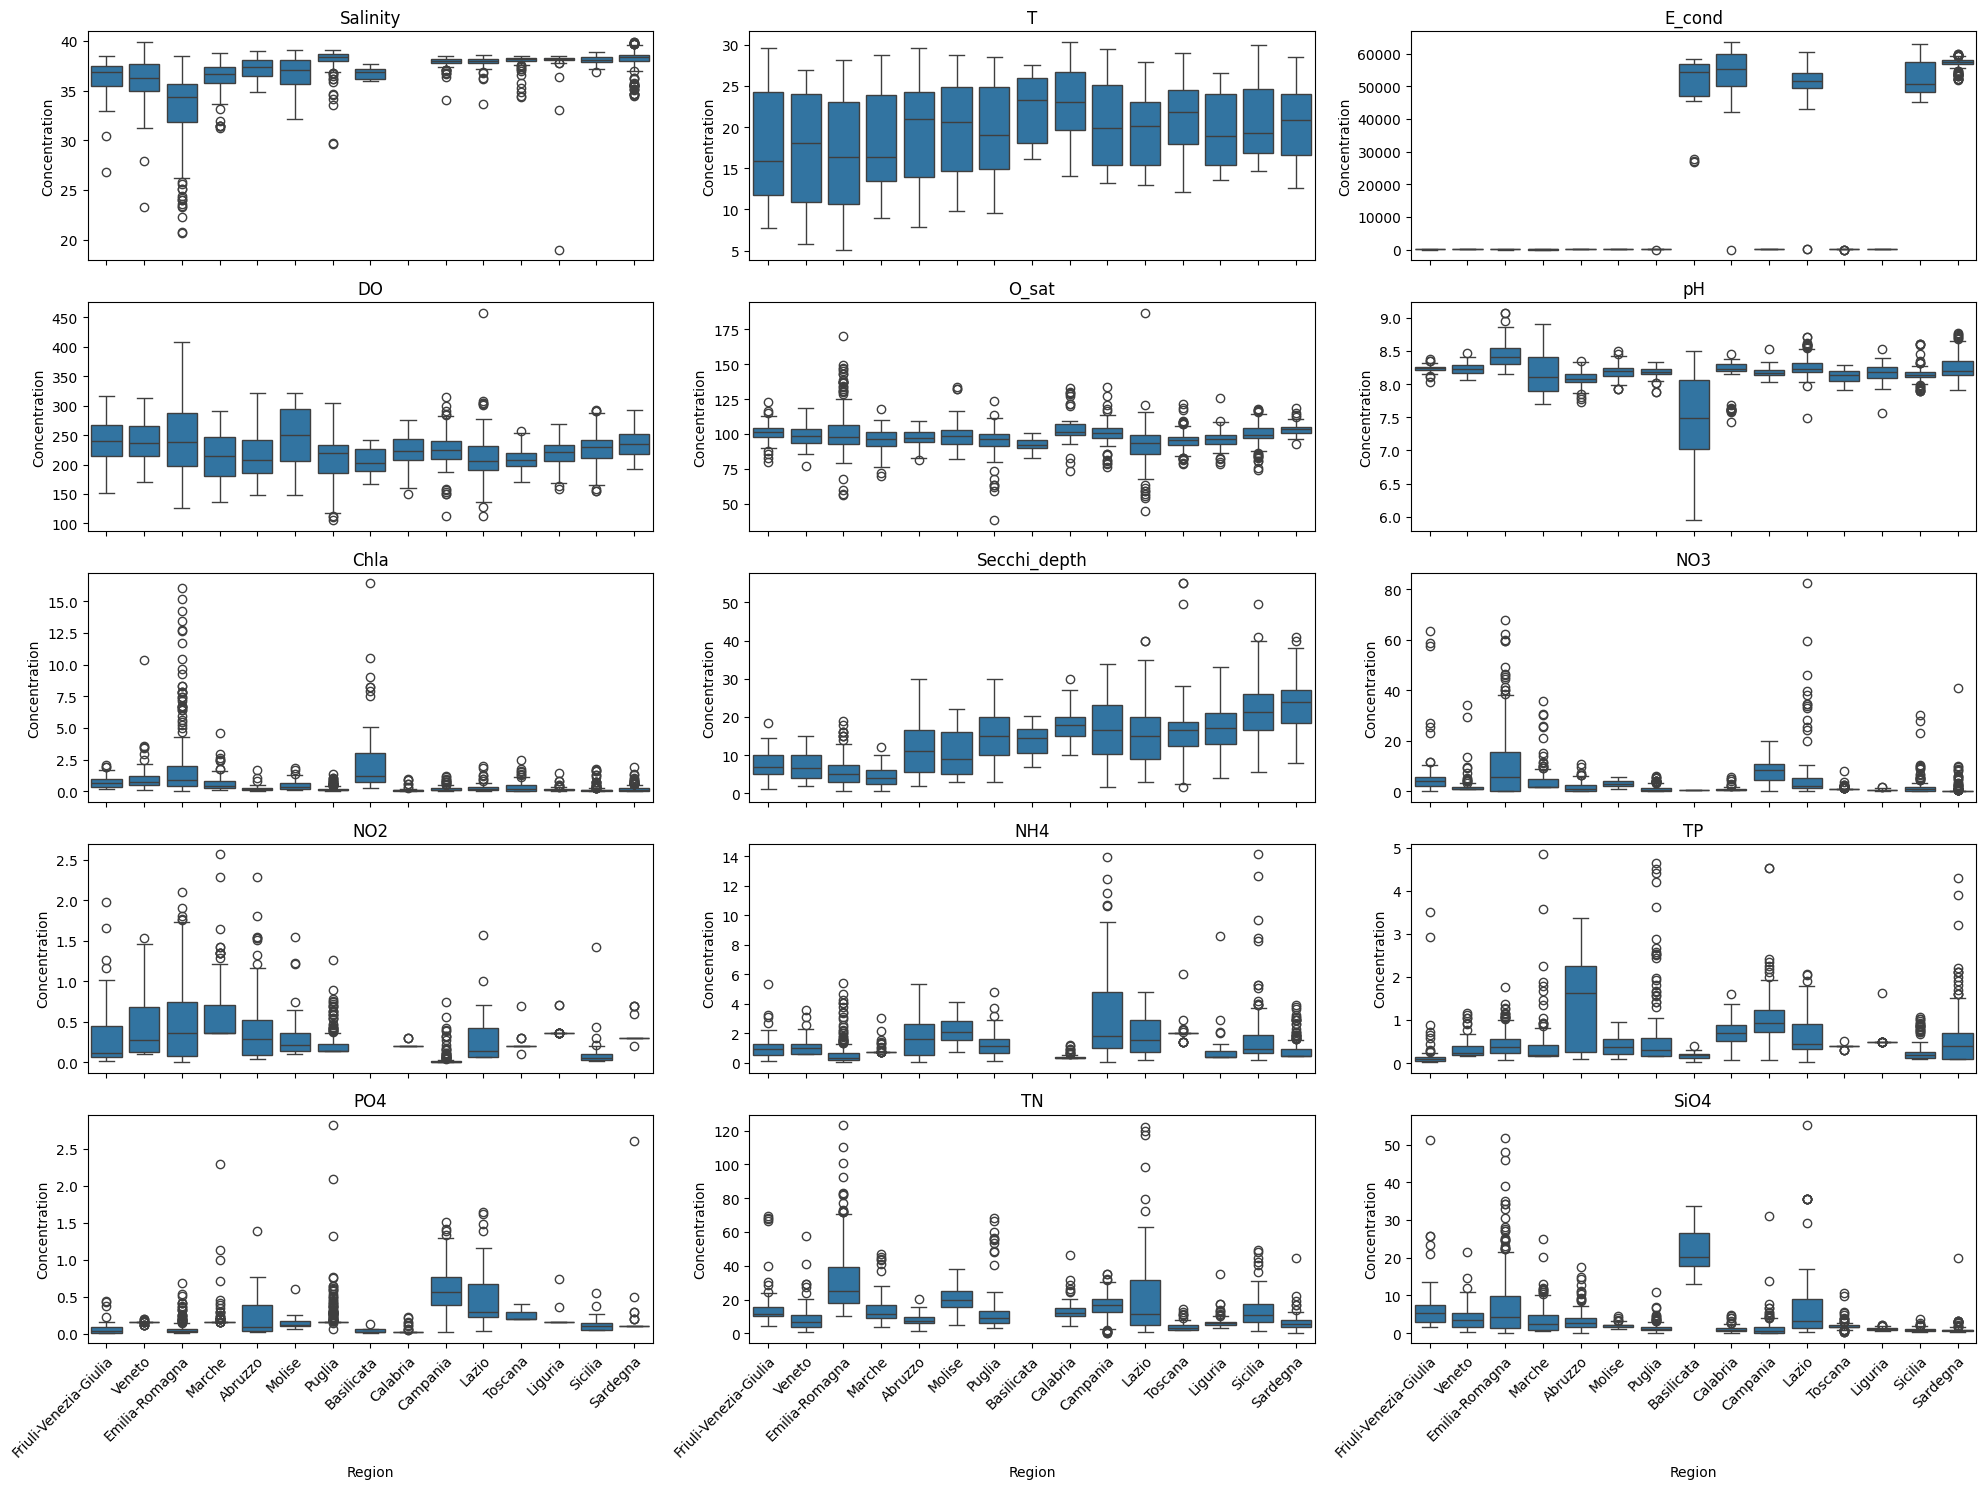

In [120]:
fig, axs = plt.subplots(5, 3, figsize=(20, 15), sharex=True)
axs = axs.ravel()
for ((nut, df_nut), ax) in zip(simplified_chem_phys.items(), axs):
    sns.boxplot(
        data=df_nut.groupby(["id", "Date"], observed = True).agg({"Concentration" : "mean", "Region" : "first"}), 
        y="Concentration", 
        x = "Region",
        legend = False,
        ax=ax)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(labels=ordered_regions, rotation=45, ha="right", rotation_mode="anchor")
    ax.set_title(nut)
plt.tight_layout()
#plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/boxplot_chem_phys.png", bbox_inches="tight")

In [15]:
env_data = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data_cleaned.xlsx", sheet_name=None, dtype = {"QF" : str})
nutrients = list(env_data.keys())

In [19]:
long_format = False
if not long_format: 
    modified_dfs = []

    # Iterate through the dictionary
    for key, df in env_data.items():
        # Rename the 'nutrient' column to the key name
        df_renamed = df.rename(columns={'nutrient': key})
        # Append the modified DataFrame to the list
        modified_dfs.append(df_renamed)
    merged_df = pd.concat(modified_dfs, axis=0)
    merged_df.pivot_table(index=["Region", "id", "Date"], columns="Nutrient", values="Concentration", aggfunc="mean").to_csv(
        _HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data_cleaned_long_format.csv"
    )

In [6]:
modified_dfs = []
# Iterate through the dictionary
for key, df in env_data.items():
    # Rename the 'nutrient' column to the key name
    # Append the modified DataFrame to the list
    modified_dfs.append(df.groupby(["Region", "id", "Date"], observed = True).agg({"Concentration" : "mean", "Nutrient" : "first"}))
env_long_all = pd.concat(modified_dfs, axis=0)
env_long_all = env_long_all.pivot_table(index=["Region", "id", "Date"], columns="Nutrient", values="Concentration")

In [22]:
env_long["N_ratio"] = (env_long["NO3"] + env_long["NH4"] + env_long["NO2"]) / env_long["TN"]
env_long["P_ratio"] = env_long["PO4"] / env_long["TP"]

In [23]:
env_long = env_long.loc[(env_long["N_ratio"] < 1.15) & (env_long["P_ratio"] < 1.15), :]

In [24]:
env_long.to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data_cleaned_long_format.csv")

## Analysis of cluster results

In [5]:
env_long = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data_cleaned_long_format.csv", index_col=[0, 1, 2])

In [6]:
cluster_index = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Results/cluster_index.csv")

In [7]:
cluster_index["Date"] = pd.to_datetime(cluster_index["Date"])

In [8]:
env_long["Date"] = pd.to_datetime(env_long["Date"])

In [9]:
env_long = pd.merge(cluster_index, env_long, on=["id", "Date"], how="inner")

In [10]:
selected_nutrients = ["T", "Salinity", "O_sat", "pH", "Chla", "NO3", "NH4", "NO2", "TN", "PO4", "TP","SiO4"]

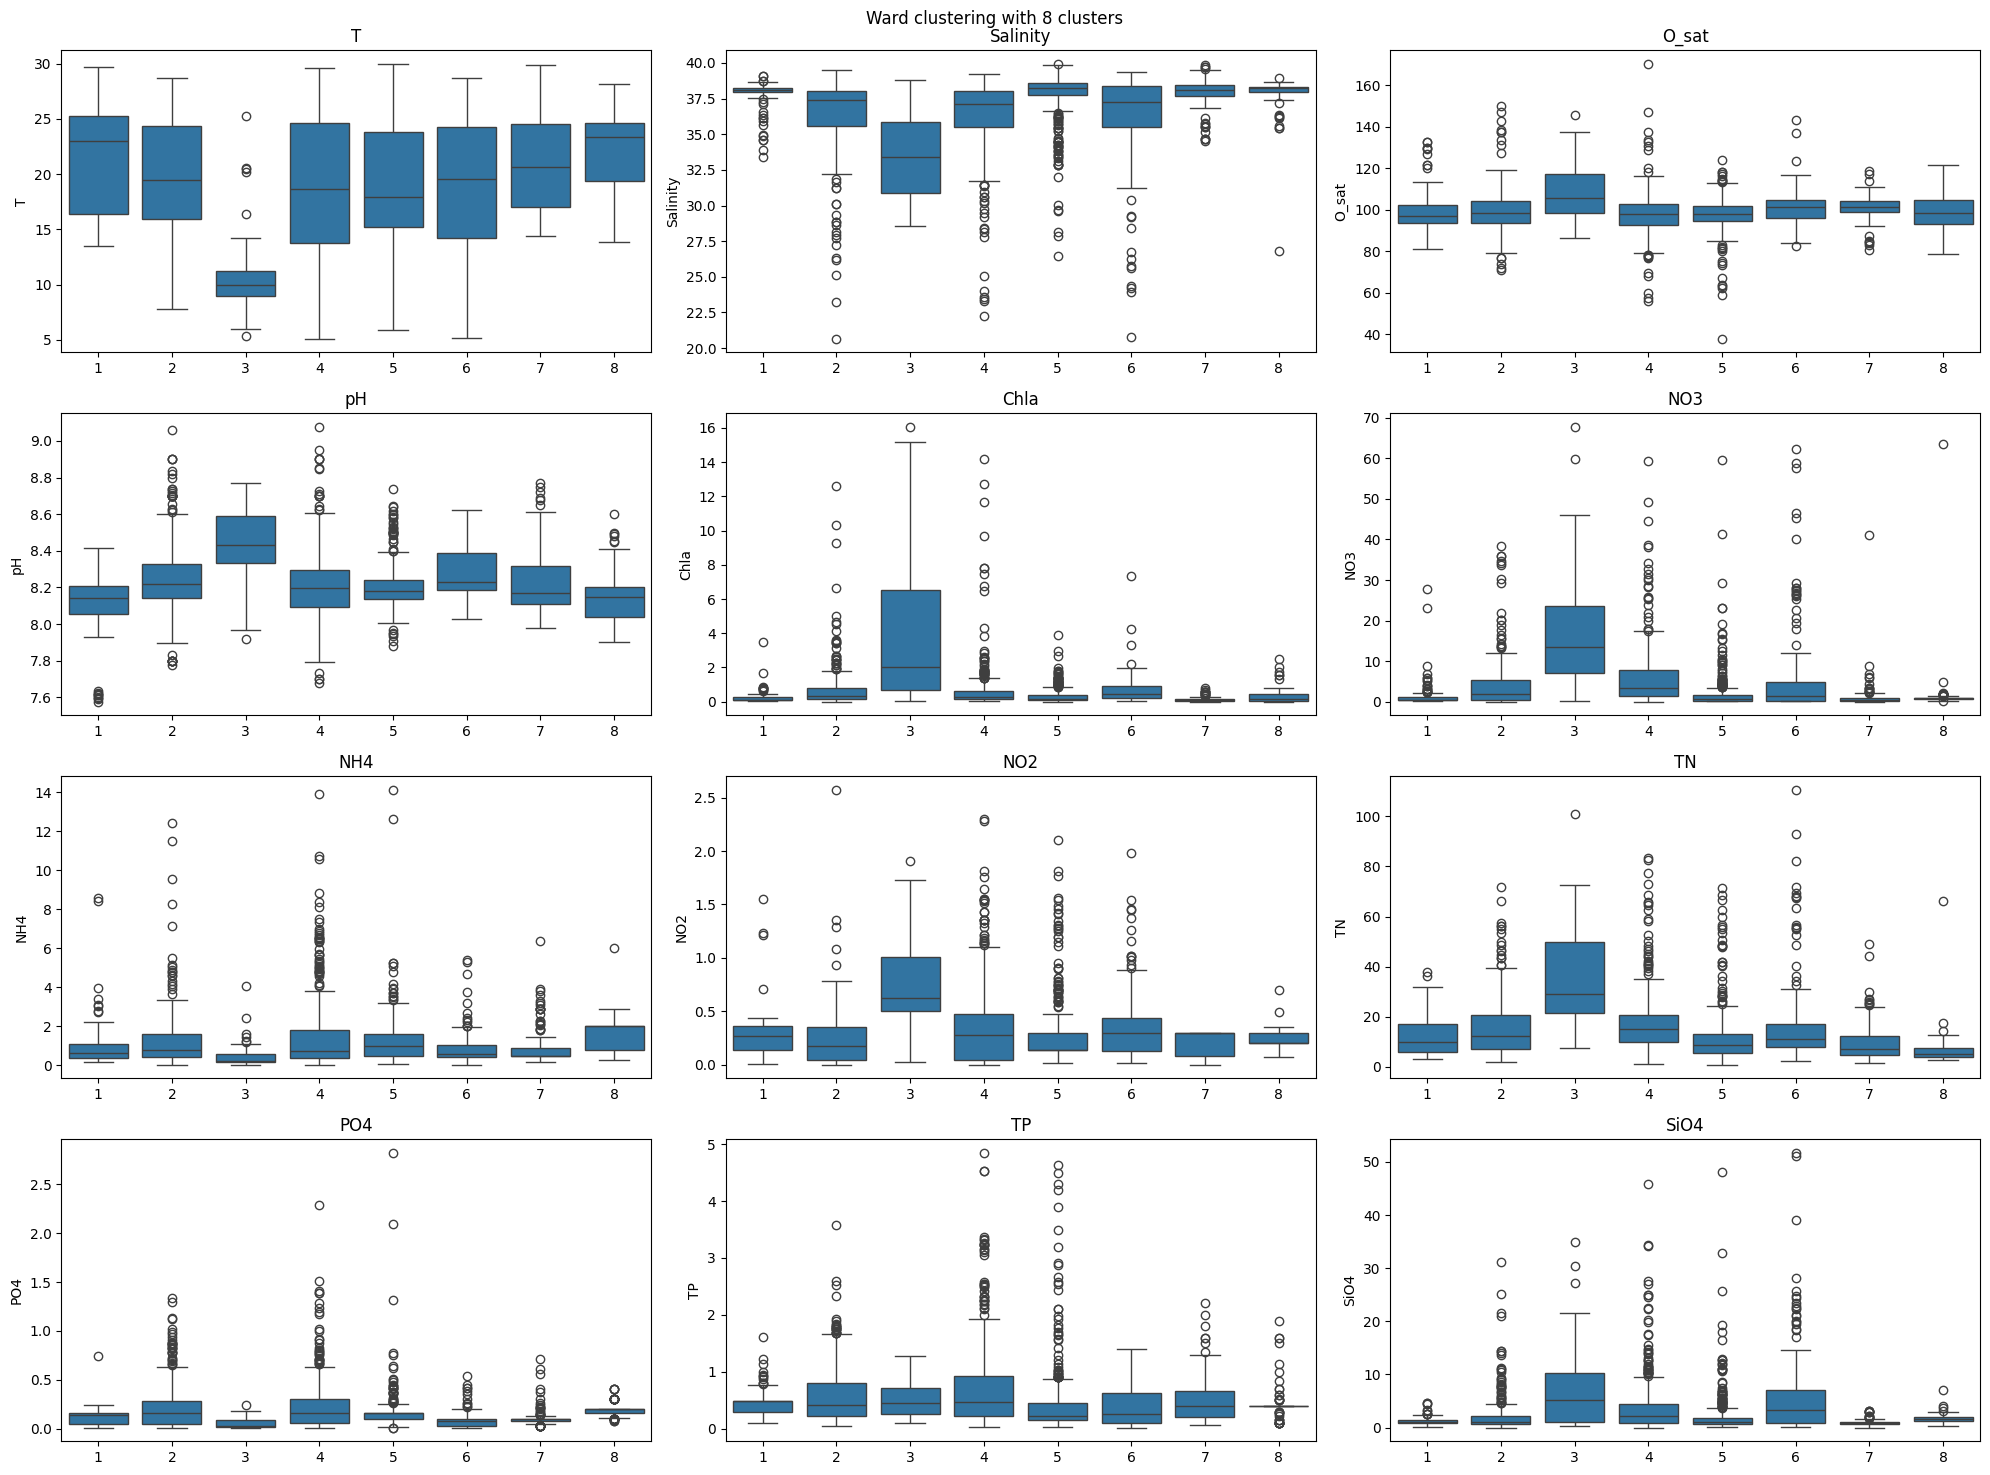

In [42]:
fig, axs = plt.subplots(4, 3, figsize=(20, 15))
axs = axs.ravel()
cluster_method = "ward_8"
for (nut, ax) in zip(selected_nutrients, axs):
    sns.boxplot(
        data=env_long, 
        y=nut, 
        x = cluster_method,
        legend = False,
        ax=ax)
    ax.set_xlabel("")
    ax.set_title(nut)
plt.suptitle(f"Ward clustering with {cluster_method.split('_')[-1]} clusters")
plt.tight_layout()

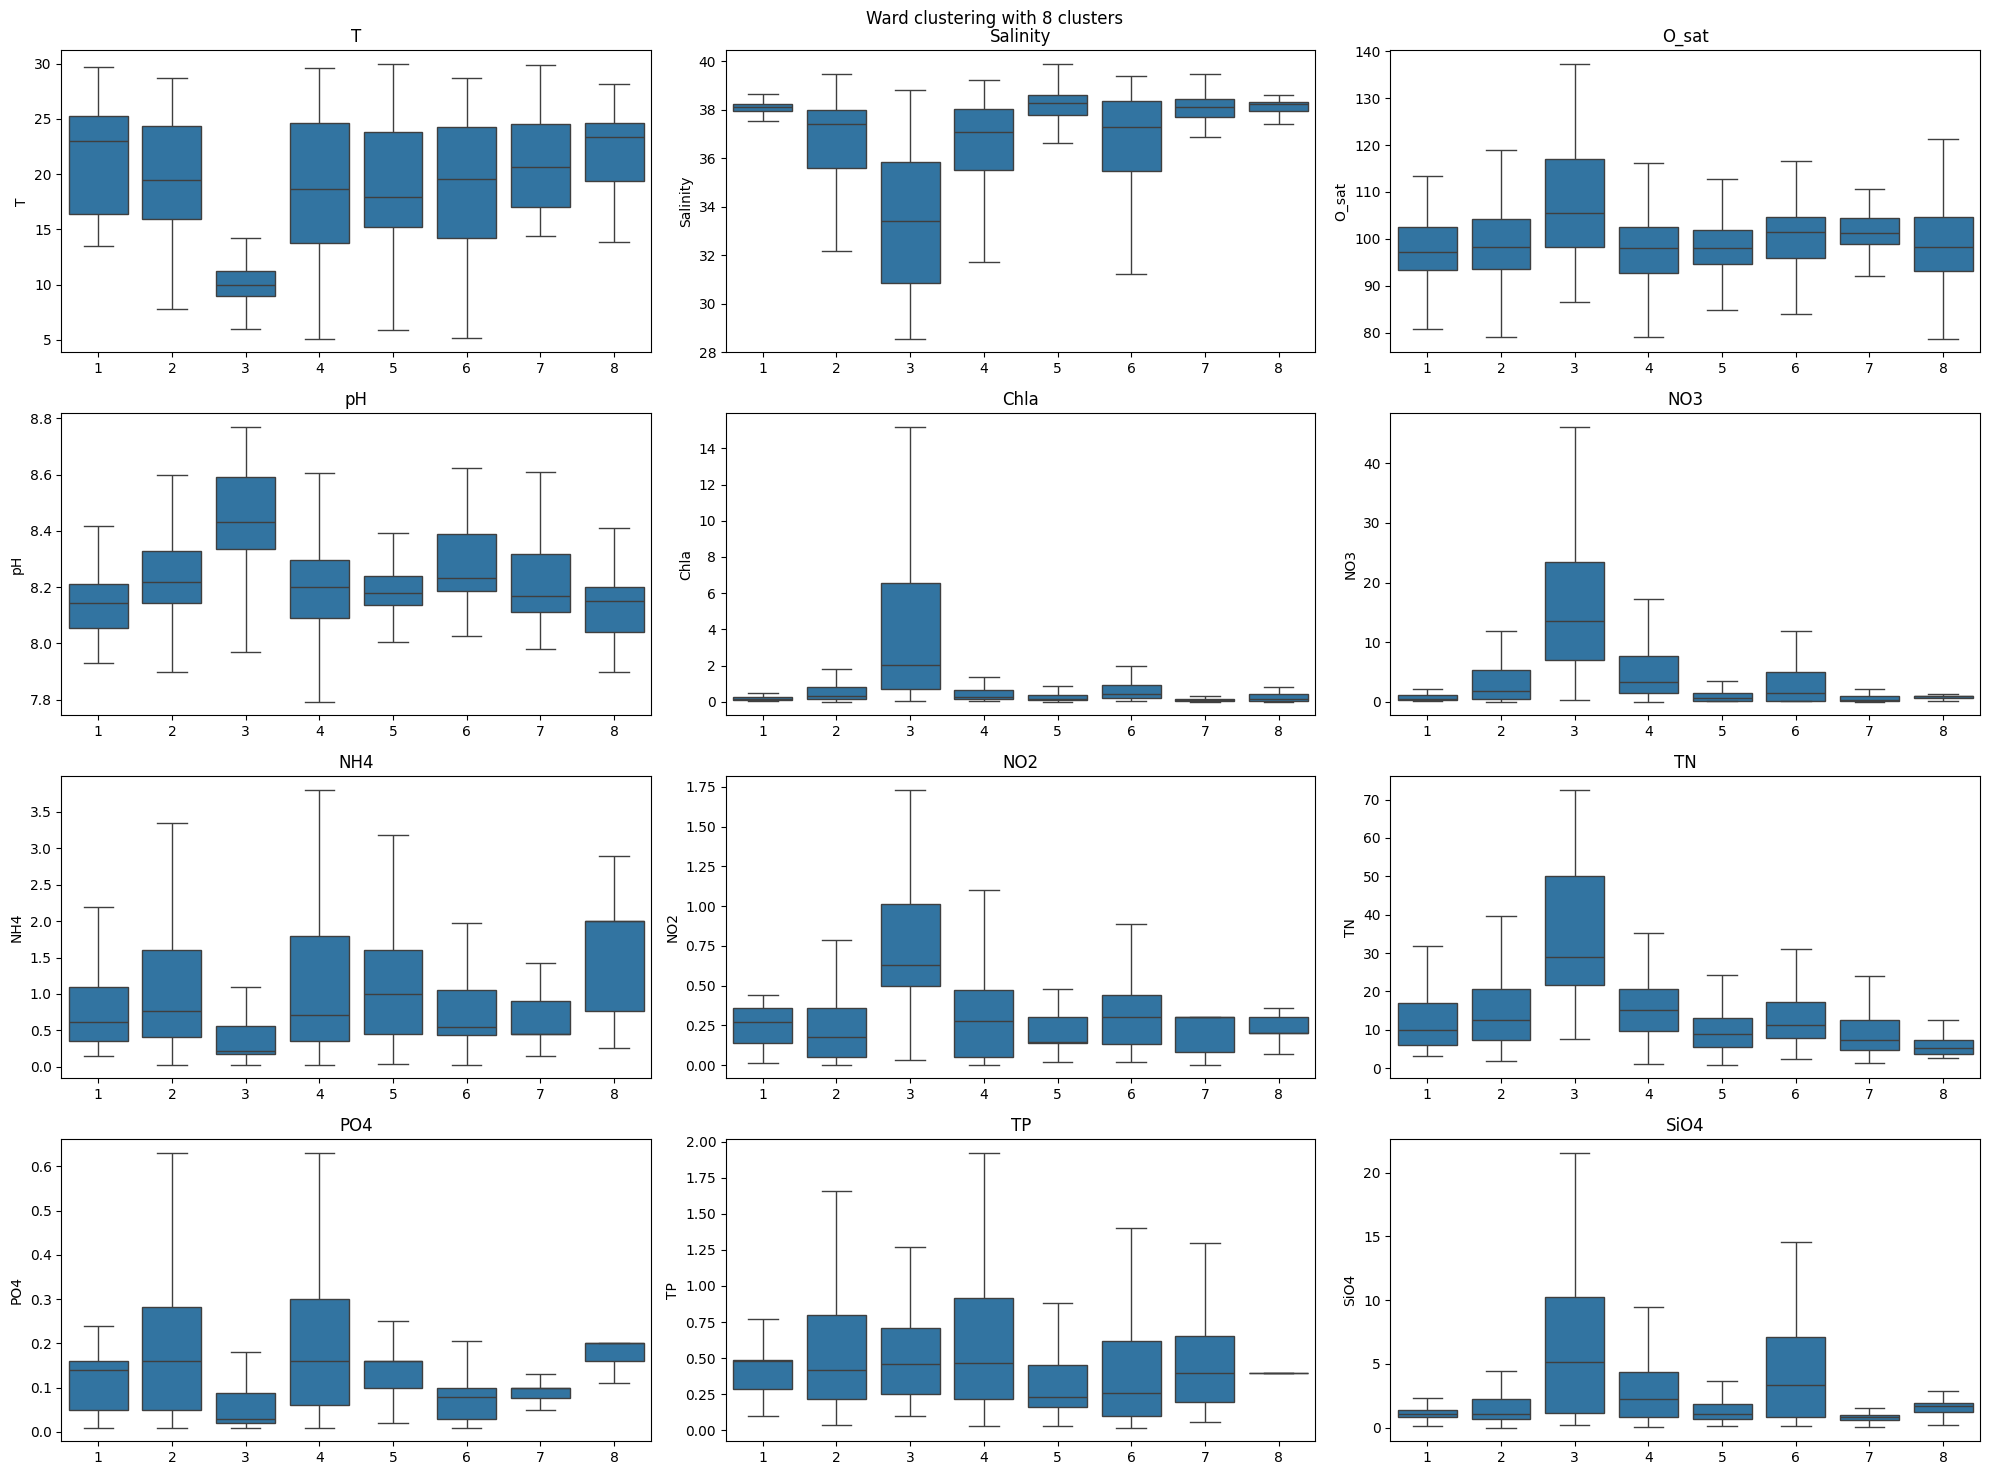

In [12]:
fig, axs = plt.subplots(4, 3, figsize=(20, 15))
axs = axs.ravel()
cluster_method = "ward_8"
for (nut, ax) in zip(selected_nutrients, axs):
    sns.boxplot(
        data=env_long, 
        y=nut, 
        x = cluster_method,
        legend = False,
        showfliers = False,
        ax=ax)
    ax.set_xlabel("")
    ax.set_title(nut)
plt.suptitle(f"Ward clustering with {cluster_method.split('_')[-1]} clusters")
plt.tight_layout()
#plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Results/boxplot_chem_phys_cluster.png", bbox_inches="tight")

In [68]:
env_long.columns

Index(['Region_x', 'Season', 'Date', 'id', 'ward_2', 'ward_3', 'ward_4',
       'ward_5', 'ward_6', 'ward_7', 'ward_8', 'ward_9', 'ward_10', 'ward_11',
       'ward_12', 'spectral_1.5_2', 'spectral_1.5_3', 'spectral_1.5_4',
       'spectral_1.5_5', 'spectral_1.5_6', 'spectral_1.5_7', 'spectral_1.5_8',
       'spectral_1.5_9', 'spectral_1.5_10', 'spectral_1.5_11',
       'spectral_1.5_12', 'Unnamed: 0', 'Region_y', 'Chla', 'DO', 'E_cond',
       'NH4', 'NO2', 'NO3', 'O_sat', 'PO4', 'Salinity', 'Secchi_depth', 'SiO4',
       'T', 'TN', 'TP', 'pH', 'N_ratio', 'P_ratio'],
      dtype='object')

<Axes: xlabel='NO3', ylabel='Count'>

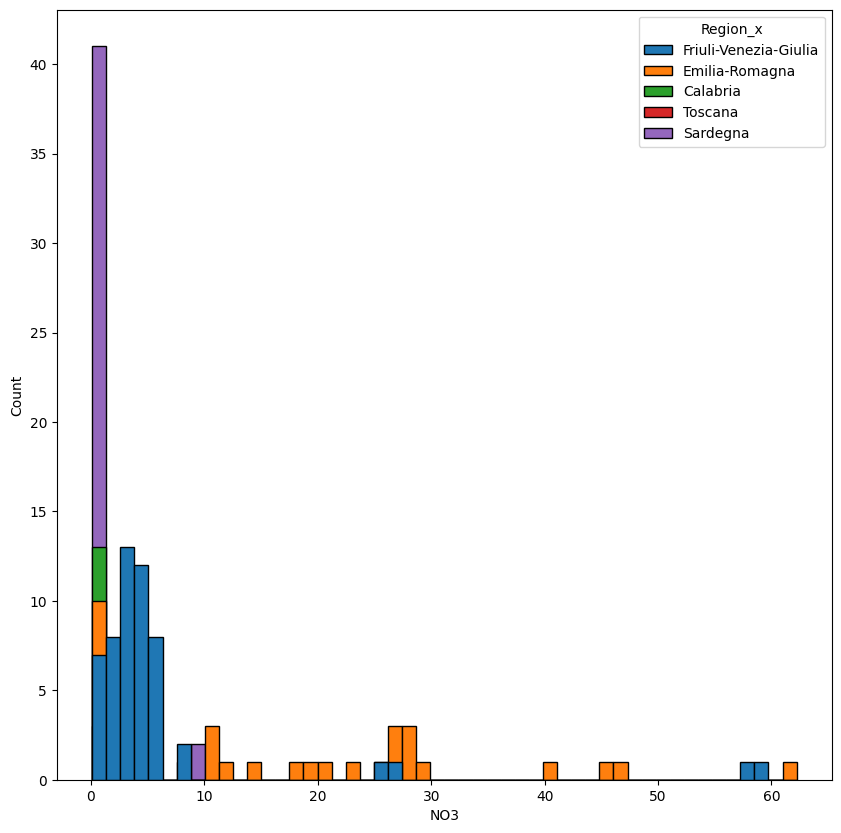

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(
    data = env_long.query("ward_8 == 6"),
    x = "NO3", 
    bins = 50, 
    hue = "Region_x", 
    alpha = 1
)

In [50]:
statistic_expr = dict([
    (nut, ["mean", "median", "var", "min", "max"]) for nut in selected_nutrients
])
env_statistics = env_long.groupby("ward_8").agg(statistic_expr)

In [48]:
env_statistics.T

ward_8                    1           2           3           4           5  \
T        mean     21.364843   19.787341   10.863379   18.621742   18.854744   
         median   23.050733   19.494238    9.937100   18.696875   17.956900   
         var      24.686862   21.714977   15.191062   37.035369   25.644415   
Salinity mean     37.775811   36.394883   33.595339   36.297582   37.786240   
         median   38.107900   37.412979   33.393183   37.100000   38.269750   
         var       1.112459    7.373970    9.026173    6.934815    2.749293   
O_sat    mean     99.406825   99.848757  107.465333   98.115539   97.722851   
         median   97.100000   98.278333  105.533333   97.950000   98.100000   
         var     112.388825  111.513735  185.492518  104.206781   62.152920   
pH       mean      8.111670    8.258720    8.425317    8.203159    8.200404   
         median    8.142833    8.216839    8.430167    8.199625    8.180000   
         var       0.033080    0.043493    0.037934    0.045068    0.012639   
Chla     mean      0.251620    0.777806    3.808053    0.697572    0.318821   
         median    0.128167    0.315000    2.013667    0.270000    0.148333   
         var       0.163430    1.955240   16.427305    2.284696    0.183244   
NO3      mean      1.500442    4.281691   16.654100    5.791763    1.819814   
         median    0.500000    1.785000   13.485000    3.385000    0.585000   
         var      11.964185   44.321299  227.286169   55.934695   20.404546   
NH4      mean      0.998883    1.285516    0.505800    1.536679    1.214318   
         median    0.610000    0.760000    0.210000    0.714000    0.998000   
         var       1.533871    2.447028    0.483108    3.678300    1.359215   
NO2      mean      0.271049    0.228150    0.724800    0.366102    0.261129   
         median    0.270000    0.178500    0.630000    0.280000    0.143000   
         var       0.046297    0.060797    0.162659    0.162245    0.086721   
TN       mean     12.635937   15.881997   36.232014   17.611866   11.358719   
         median   10.000000   12.461180   29.075000   15.095000    8.824500   
         var      63.207987  143.423121  429.074149  154.521219  106.768270   
PO4      mean      0.115244    0.237096    0.059526    0.232230    0.163092   
         median    0.140000    0.160000    0.030000    0.161000    0.160000   
         var       0.006517    0.069609    0.003330    0.075804    0.033639   
TP       mean      0.455383    0.597261    0.511900    0.746065    0.435527   
         median    0.480000    0.415000    0.460000    0.465000    0.230000   
         var       0.062117    0.289076    0.089883    0.619403    0.375535   
SiO4     mean      1.245328    2.321118    7.053400    3.889499    2.102923   
         median    1.090000    1.030000    5.145000    2.210000    1.100000   
         var       0.600408   13.927343   61.382288   29.694707   13.793815   

ward_8                    6           7          8  
T        mean     18.656192   20.782370  22.158915  
         median   19.530000   20.617700  23.395075  
         var      38.477385   17.395772  12.210684  
Salinity mean     36.093449   37.993976  37.908776  
         median   37.287067   38.136038  38.259800  
         var      12.713610    0.986057   1.735315  
O_sat    mean    101.057991  101.309017  98.448892  
         median  101.408333  101.183333  98.200000  
         var      65.926737   30.787531  57.436243  
pH       mean      8.282224    8.232403   8.147621  
         median    8.231000    8.169167   8.149500  
         var       0.020739    0.029447   0.022587  
Chla     mean      0.682998    0.134823   0.320457  
         median    0.453833    0.075000   0.135000  
         var       0.715050    0.020522   0.207514  
NO3      mean      6.378333    1.093787   1.527816  
         median    1.400000    0.360000   0.900000  
         var     139.126838   11.587887  40.550970  
NH4      mean      0.876203    0.884790   1.607857  
         median 

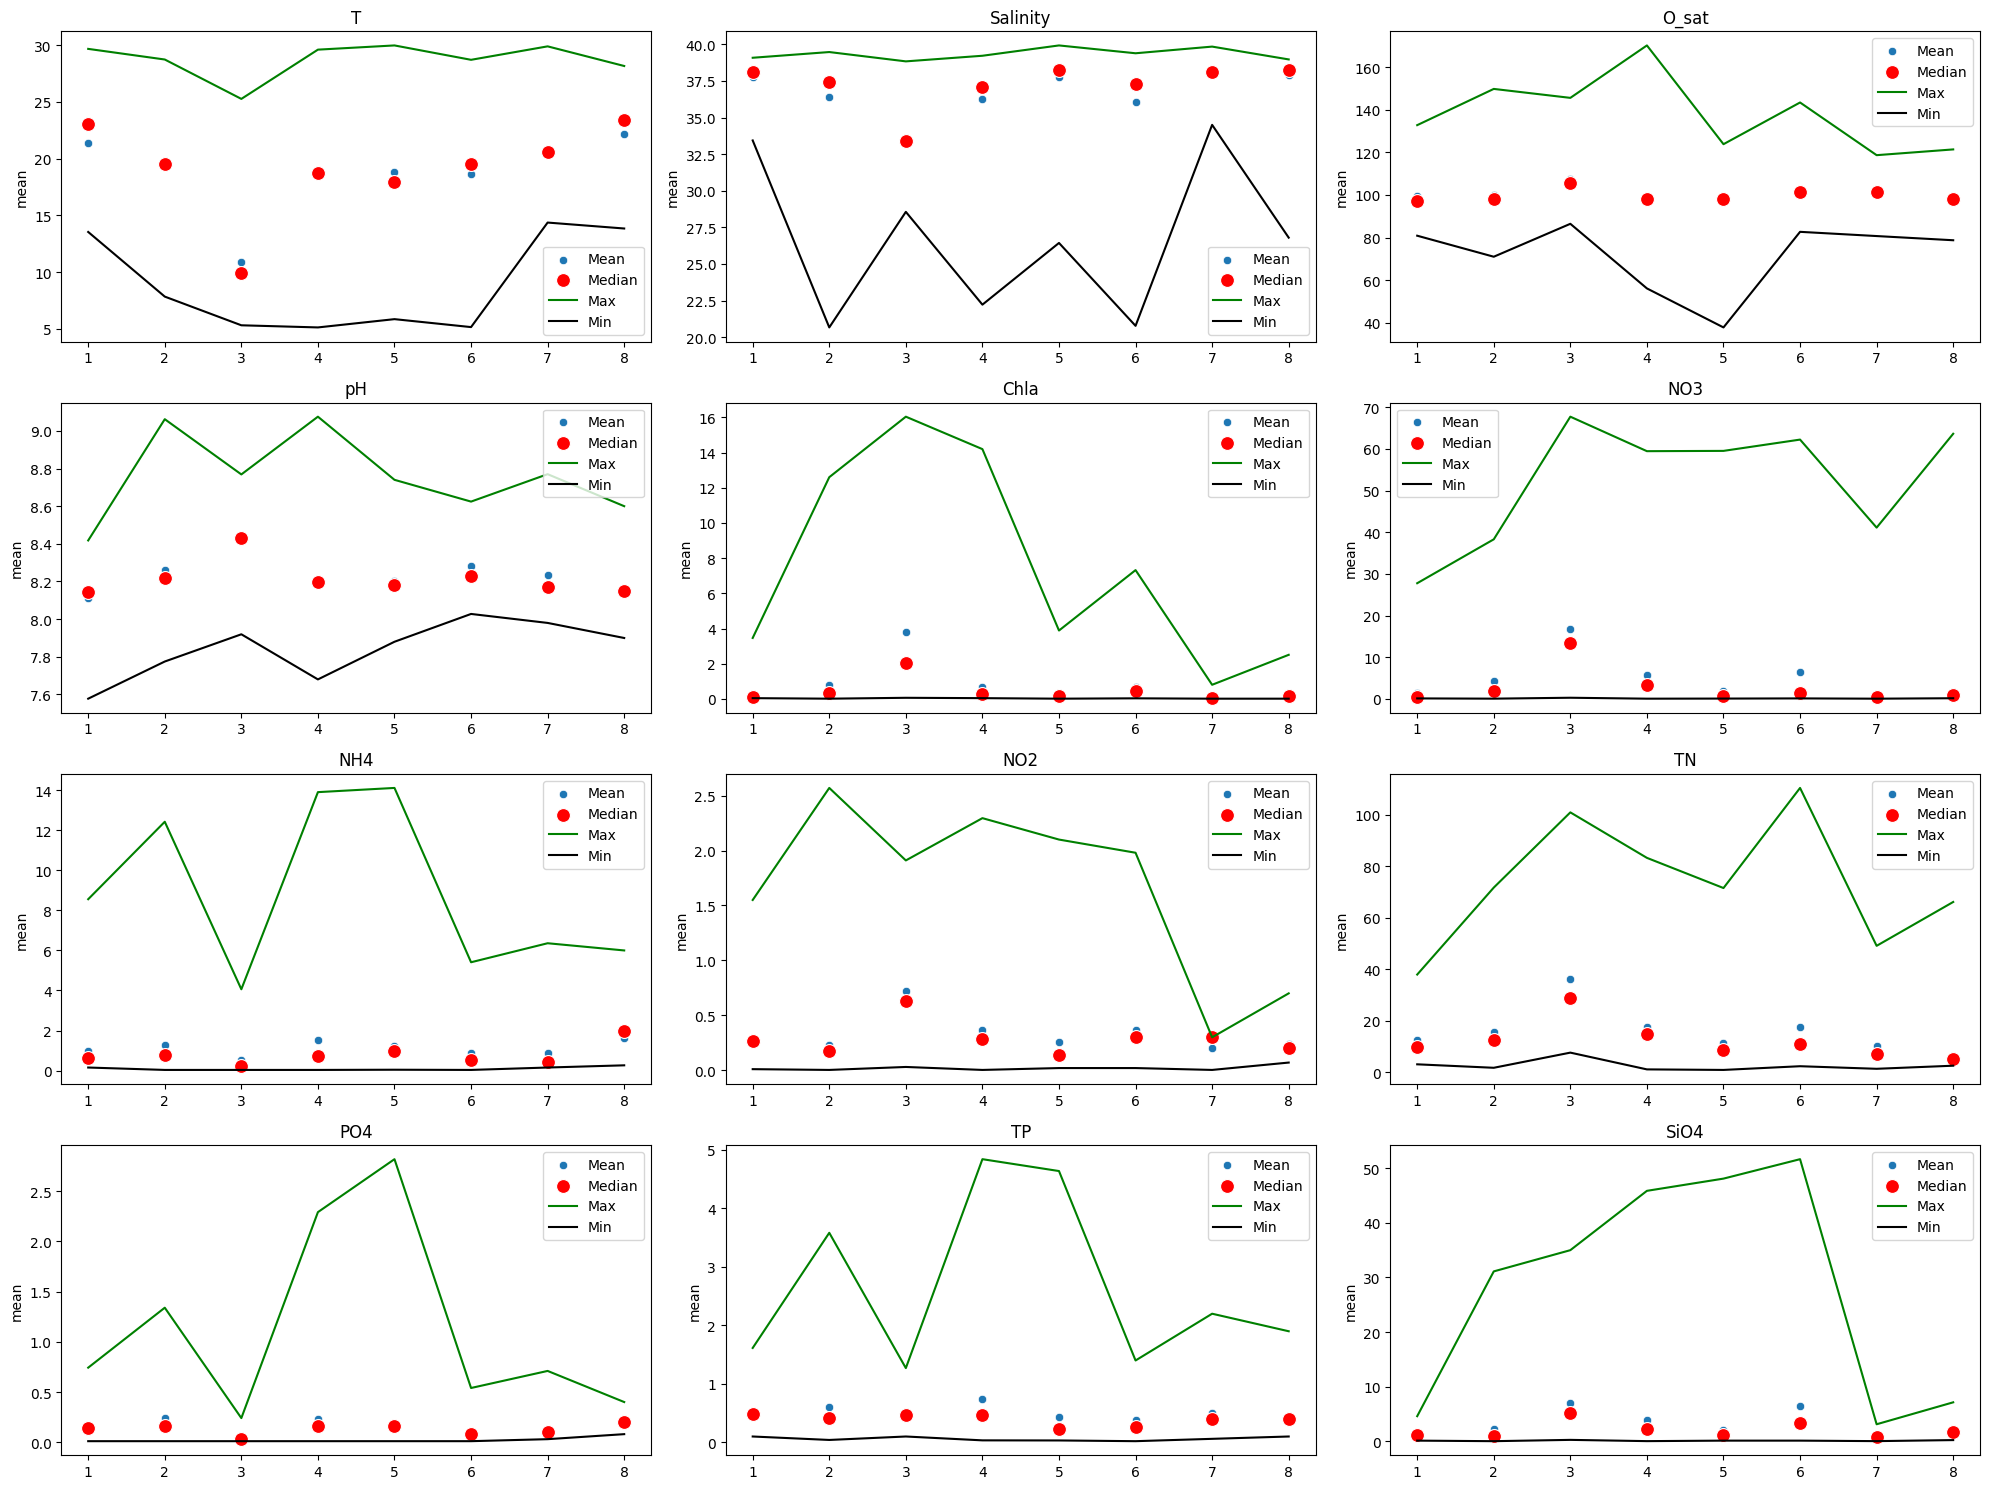

In [51]:
fig, axs = plt.subplots(4, 3, figsize=(20, 15))
axs = axs.ravel()
for (nut, ax ) in zip(selected_nutrients, axs): 
    sns.scatterplot(data=env_statistics.loc[:, nut], x=env_statistics.loc[:, nut].index, y='mean', marker='o', label='Mean', ax = ax)
    sns.scatterplot(data=env_statistics.loc[:, nut], x=env_statistics.loc[:, nut].index, y='median', color='red', s=100, label='Median', ax = ax)
    sns.lineplot(data=env_statistics.loc[:, nut], x=env_statistics.loc[:, nut].index, y='max', color='green', label='Max', ax = ax)
    sns.lineplot(data=env_statistics.loc[:, nut], x=env_statistics.loc[:, nut].index, y='min', color='black',  label='Min', ax = ax)
    ax.set_title(nut)
    ax.set_xlabel("")
plt.tight_layout()

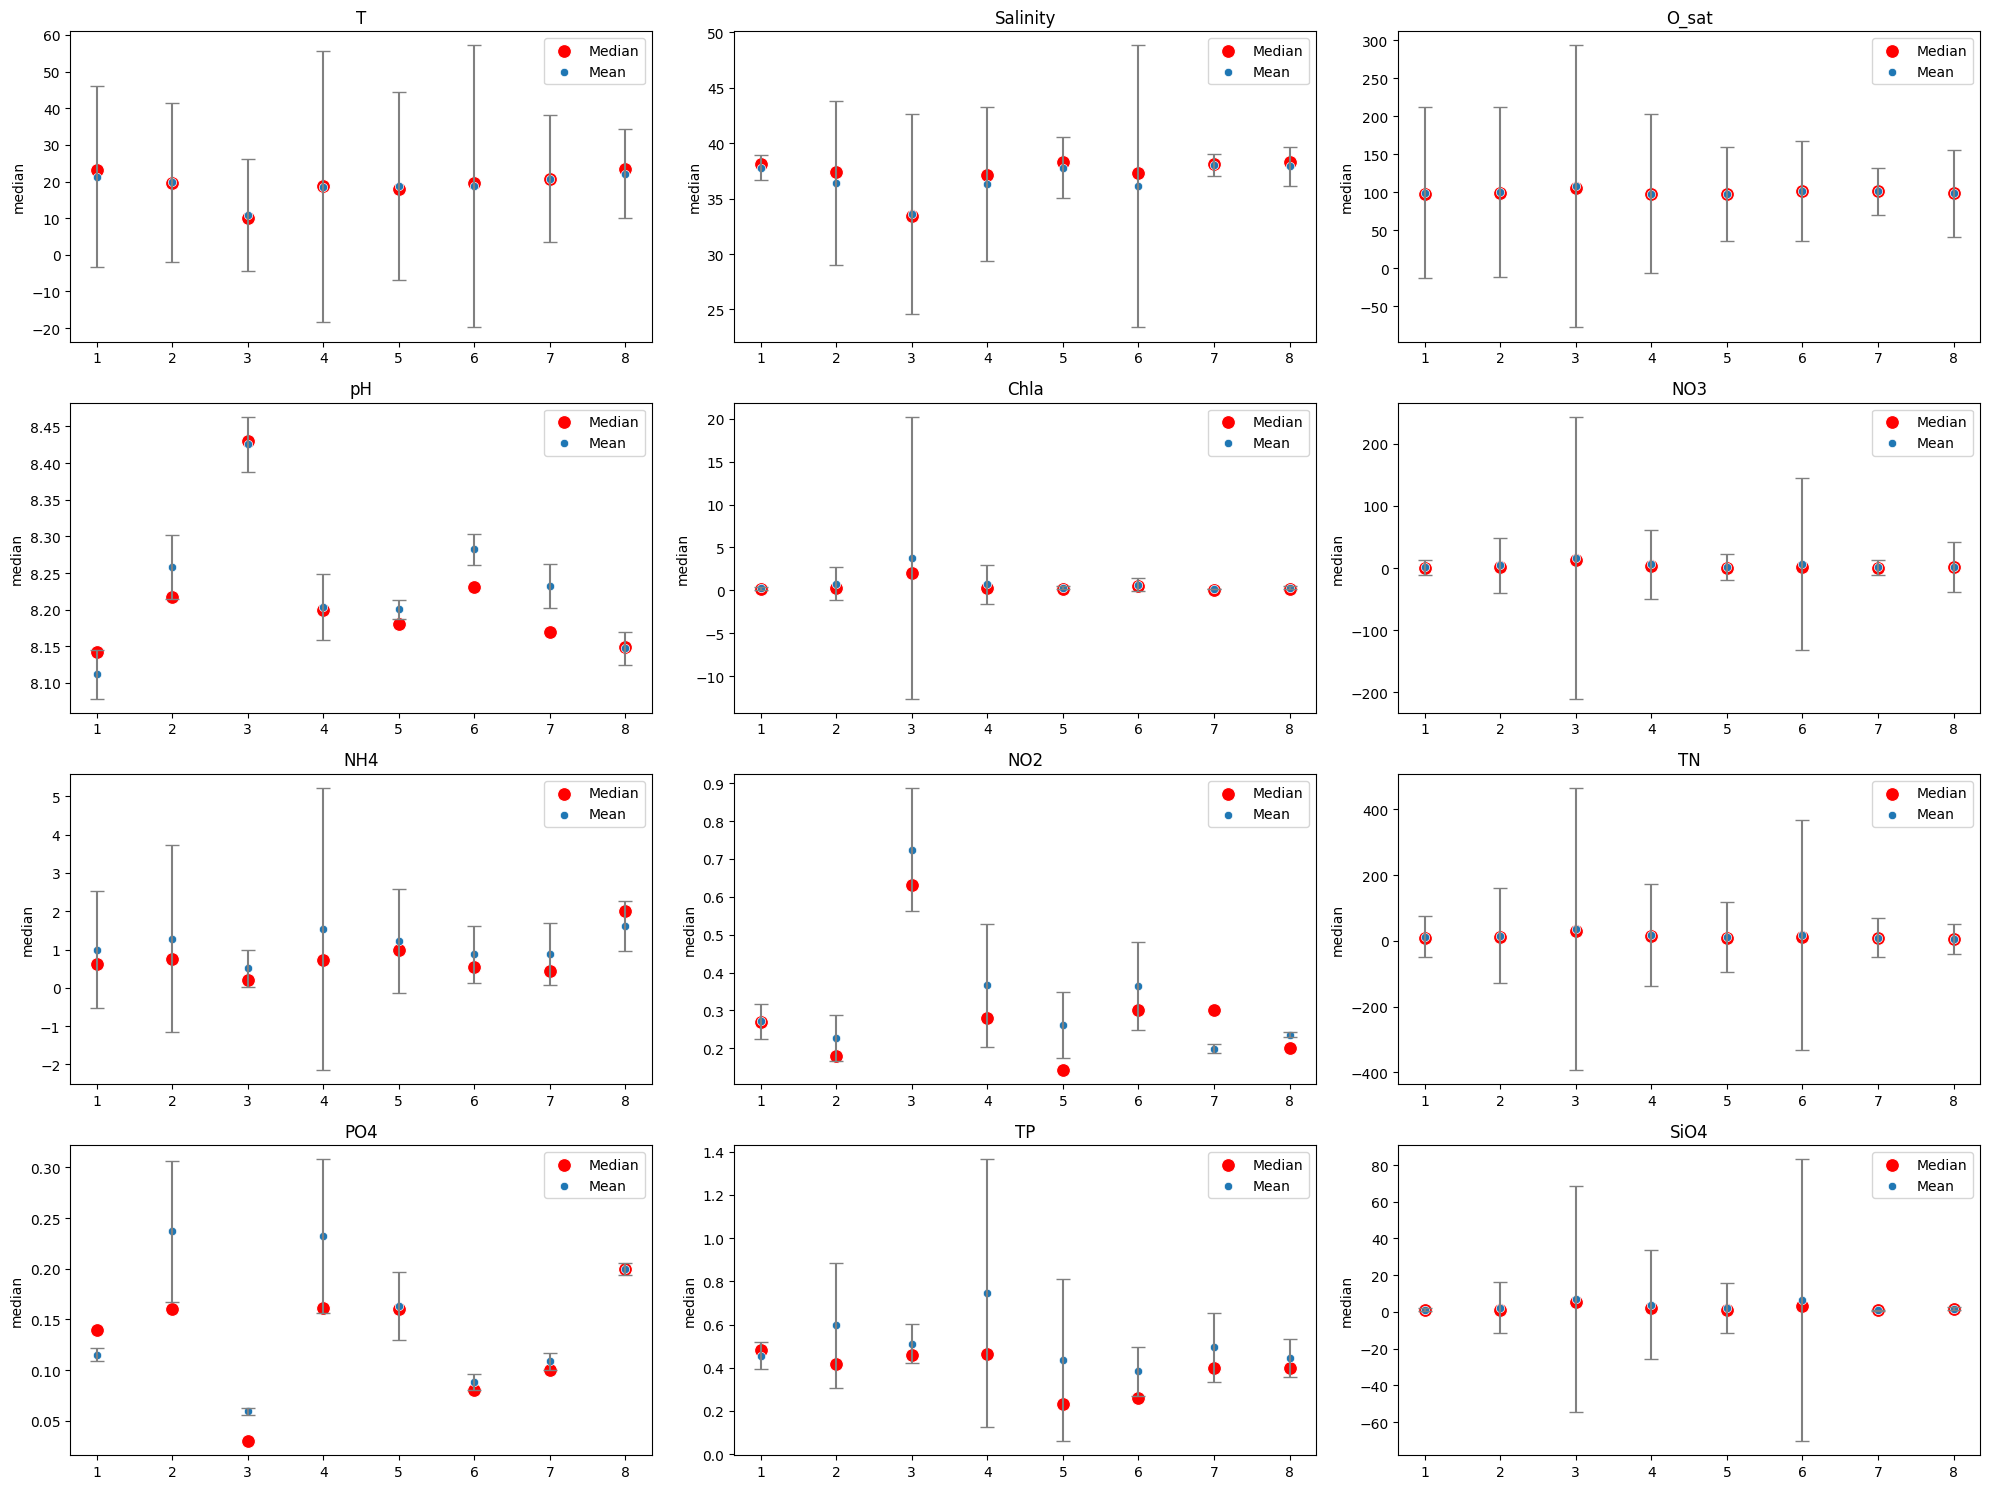

In [47]:
fig, axs = plt.subplots(4, 3, figsize=(20, 15))
axs = axs.ravel()
for (nut, ax ) in zip(selected_nutrients, axs): 
    sns.scatterplot(data=env_statistics.loc[:, nut], x=env_statistics.loc[:, nut].index, y='median', color='red', s=100, label='Median', ax = ax)
    sns.scatterplot(data=env_statistics.loc[:, nut], x=env_statistics.loc[:, nut].index, y='mean', marker='o', label='Mean', ax = ax)
    ax.errorbar(x=env_statistics.loc[:, nut].index, y=env_statistics.loc[:, nut]['mean'], yerr=env_statistics.loc[:, nut]['var'], fmt='none', capsize=5, color='gray')
    ax.set_title(nut)
    ax.set_xlabel("")
plt.tight_layout()

<Axes: xlabel='NH4', ylabel='Count'>

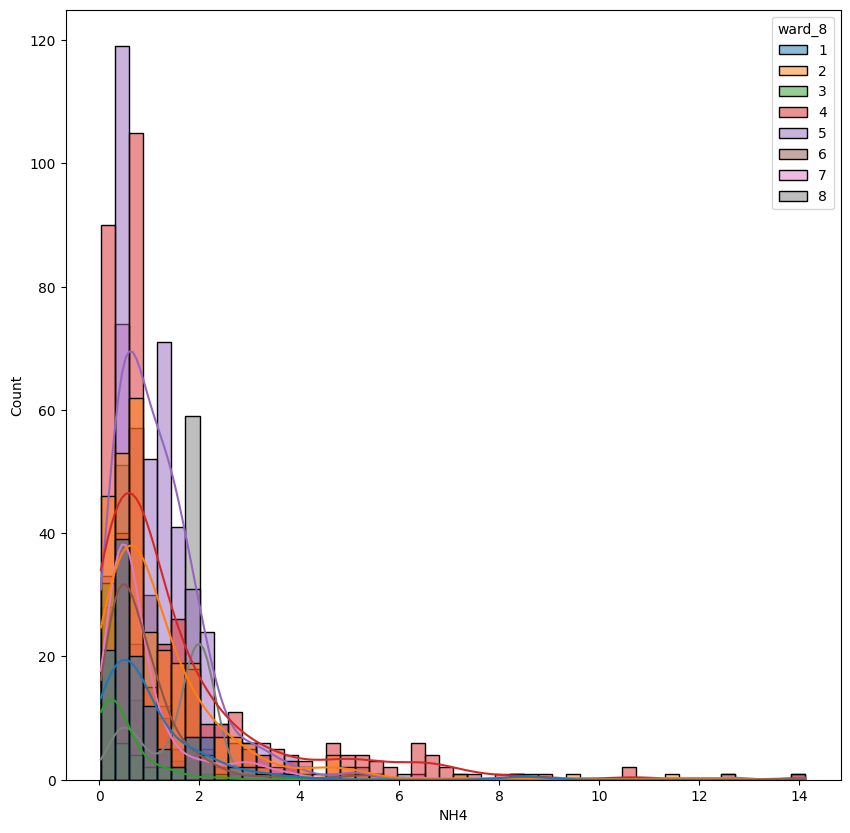

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cluster_method = "ward_8"
sns.histplot(
    data=env_long, 
    x="NH4", 
    hue = cluster_method,
    palette="tab10",
    ax=ax, 
    bins=50, 
    kde = True)

<Axes: xlabel='Chla', ylabel='Count'>

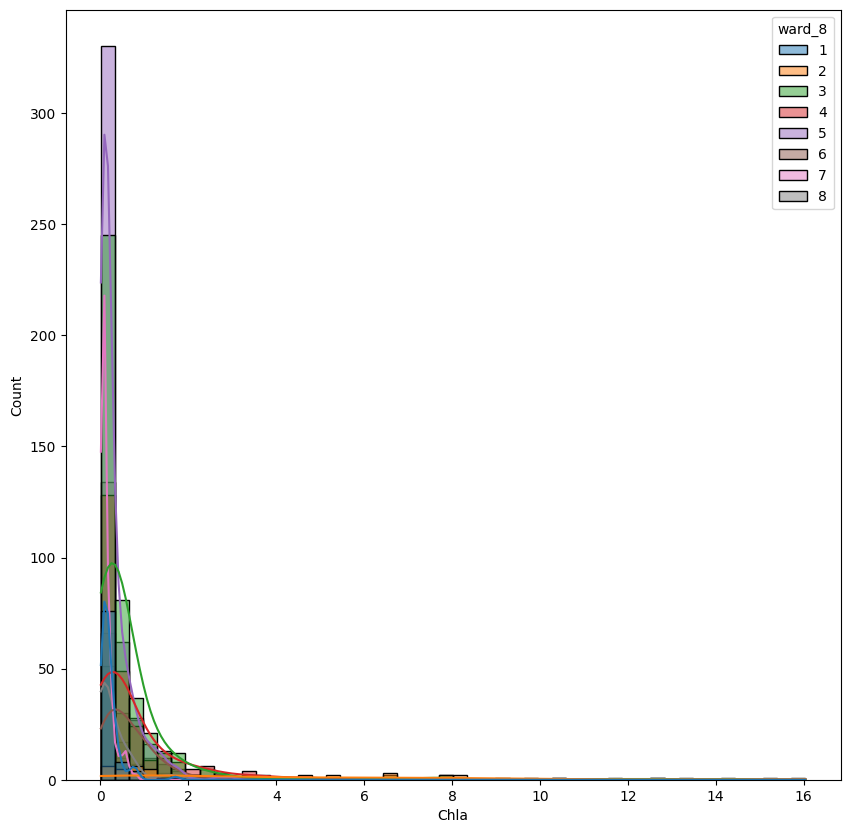

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(
    data=env_long, 
    x="Chla", 
    hue = cluster_method,
    palette="tab10",
    ax=ax, 
    bins=50, 
    kde = True)

<Axes: xlabel='P_ratio', ylabel='Count'>

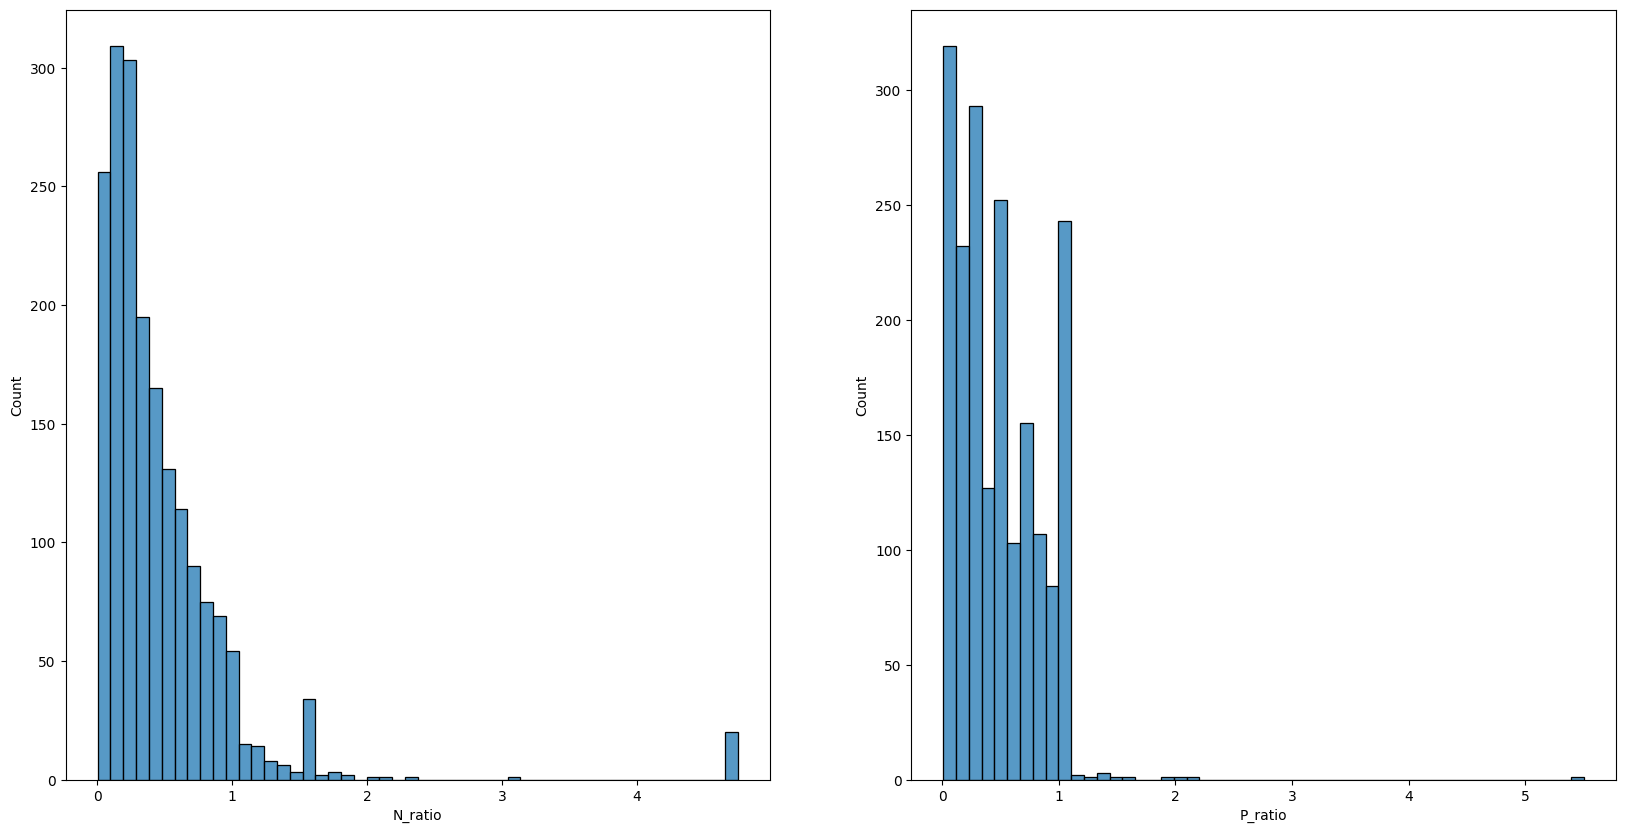

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.histplot(data=env_long_all, x="N_ratio", bins=50, ax=axs[0])
sns.histplot(data=env_long_all, x="P_ratio", bins=50, ax=axs[1])

<Axes: xlabel='Nutrient', ylabel='Nutrient'>

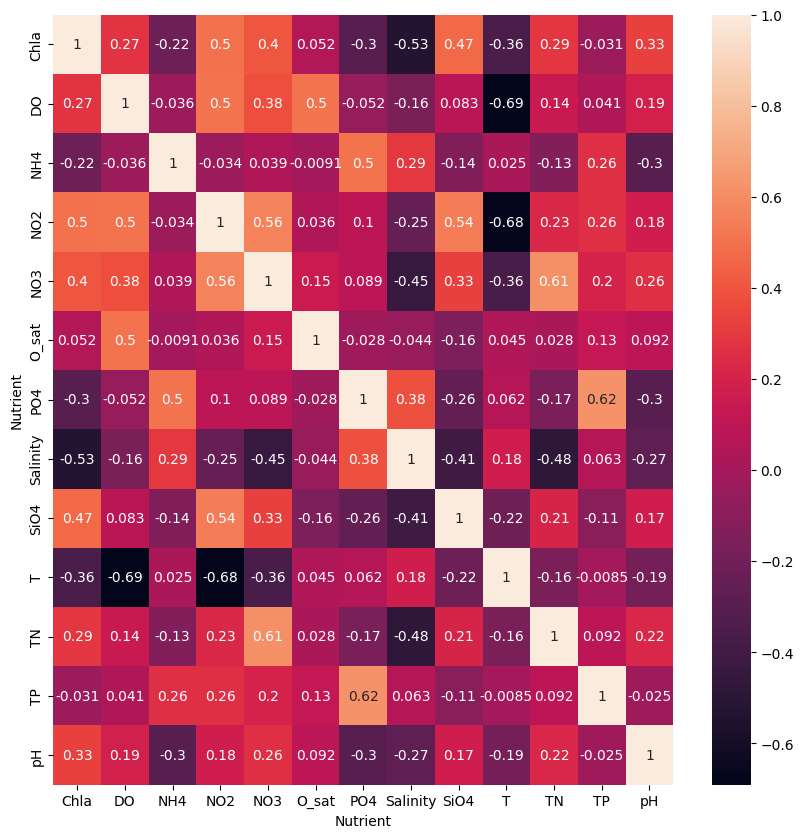

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(env_long.loc[:, 
             ['Chla', 'DO', 'NH4', 'NO2', 'NO3', 'O_sat', 'PO4', 'Salinity', 'SiO4', 'T', 'TN', 'TP', 'pH']
             ].corr(method = "spearman"), 
             ax = ax, 
            annot=True,
             )